# Skin Cancer Classification

## **Initialization**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = 'archive' 

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# Reading Metadata CSV of the dataset

tile_df = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

# Adding path to image and name of Cancer type

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9725,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,archive\HAM10000_images_part_1\ISIC_0024843.jpg,Actinic keratoses,0
6059,HAM_0003024,ISIC_0024768,nv,follow_up,35.0,female,trunk,archive\HAM10000_images_part_1\ISIC_0024768.jpg,Melanocytic nevi,4
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,archive\HAM10000_images_part_1\ISIC_0026564.jpg,Melanocytic nevi,4
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,archive\HAM10000_images_part_2\ISIC_0029346.jpg,Melanocytic nevi,4
7914,HAM_0000443,ISIC_0034271,nv,histo,35.0,female,back,archive\HAM10000_images_part_2\ISIC_0034271.jpg,Melanocytic nevi,4


In [5]:
tile_df['path'][10002]

'archive\\HAM10000_images_part_2\\ISIC_0032947.jpg'

## Data Analysis

In [6]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0030821,nv,histo,male,back,archive\HAM10000_images_part_2\ISIC_0031383.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


<AxesSubplot:>

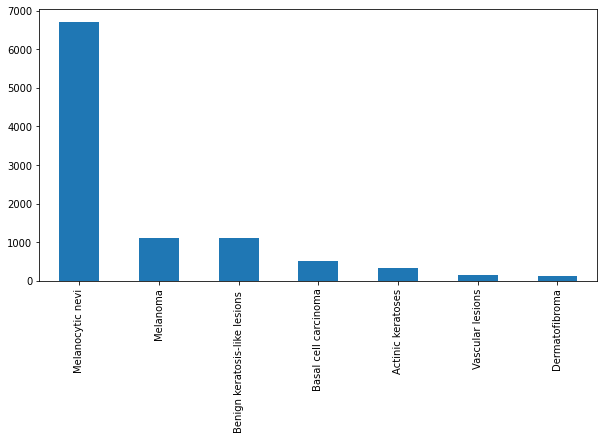

In [7]:
# Visualizing the distribution by Types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### Initial attempt by dropping ~5000 Melanocytic Nevi images !! Don't run.

In [8]:
# tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)
# fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
# tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

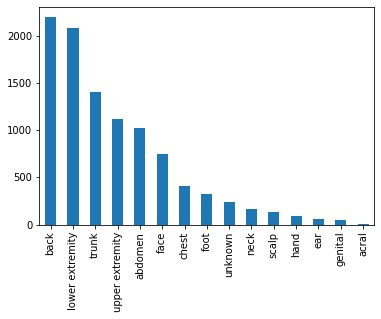

In [9]:
# Visualizing distribution by localization

tile_df['localization'].value_counts().plot(kind='bar')

<AxesSubplot:>

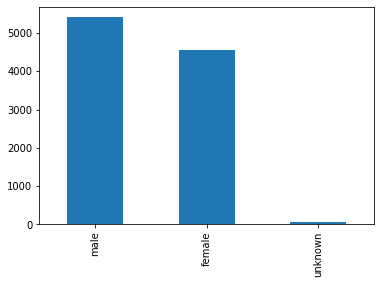

In [10]:
# Visualizing distribution by sex

tile_df['sex'].value_counts().plot(kind='bar')

**Import and resize images**

In [11]:
# Loading Images into the dataframe and resizing

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

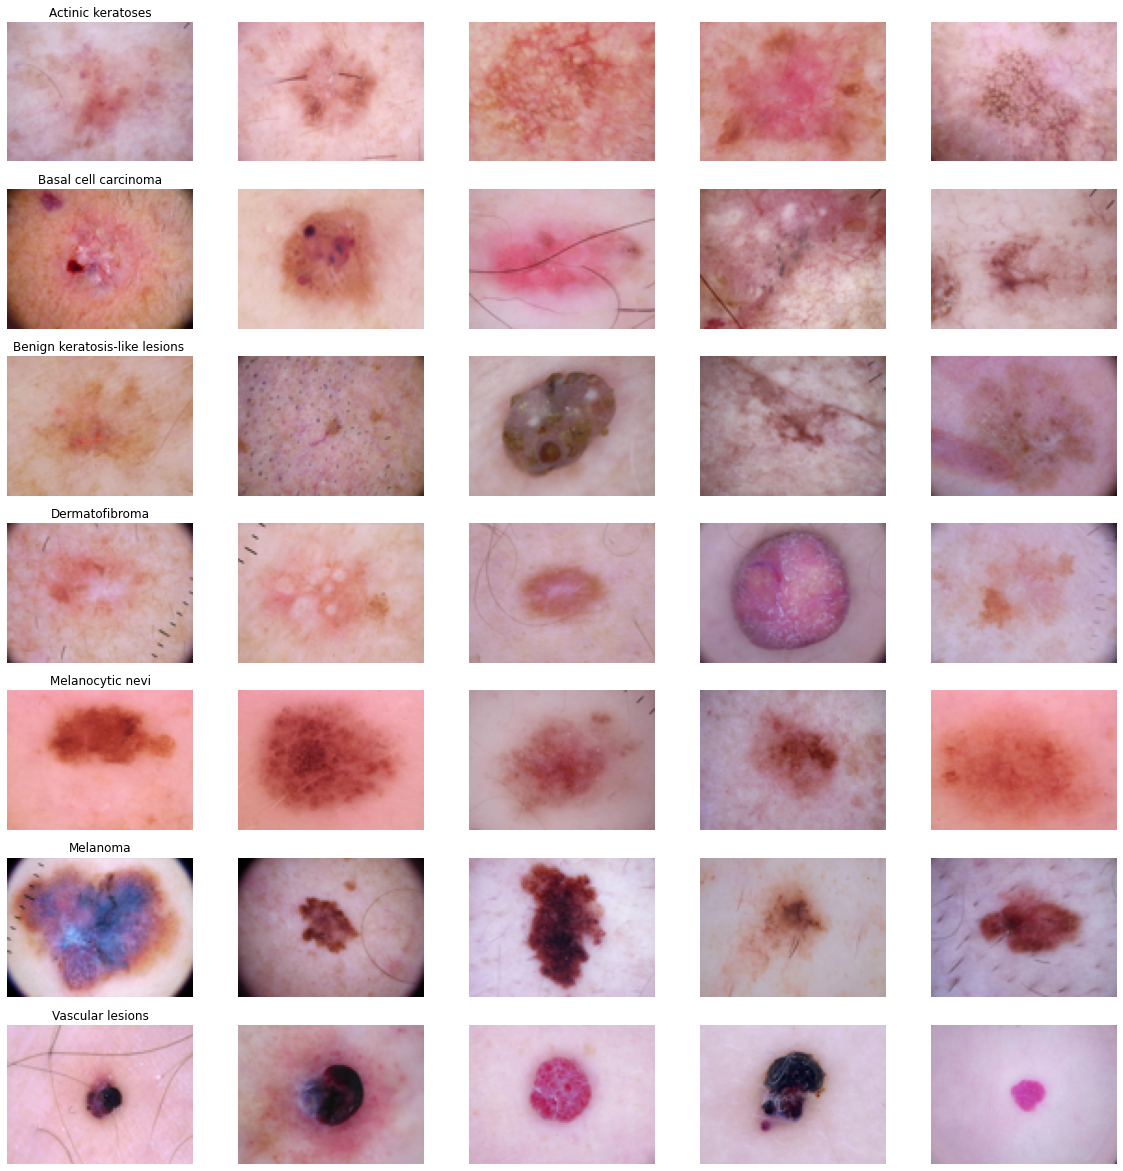

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('sample_images.png', dpi=300)

**Color channel analysis**

How do the normalized color samples vary across different types of skin diseases?

In [13]:
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
4007,1.255332,0.829746,0.914921,182.010667
8796,1.041179,0.948532,1.010289,187.749733
7692,1.067634,0.919133,1.013233,155.863067
872,1.135692,0.889376,0.974932,150.821111
1016,1.335383,0.844598,0.820019,169.370533
8997,1.125208,0.896953,0.977839,170.731422
5179,1.583980,0.706253,0.709767,117.379156
870,1.131821,0.906385,0.961795,154.177333
9025,1.079352,0.957752,0.962896,165.054800
5009,1.405499,0.827750,0.766751,159.125511


In [14]:
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values

In [15]:
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

### Creating train and test sets

In [16]:
y = tile_df.cell_type_idx

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [18]:
datagen = ImageDataGenerator()
balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch


MemoryError: Unable to allocate array with shape (4907, 22500) and data type float64

<AxesSubplot:>

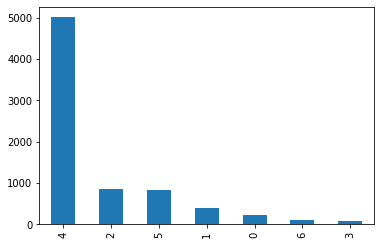

In [20]:
y_train_o.value_counts().plot(kind='bar')

<AxesSubplot:>

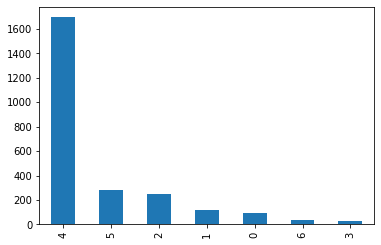

In [21]:
y_test_o.value_counts().plot(kind='bar')

### Basic CNN -- 0.41 train acc, 0.36 validation acc

In [22]:
# input_shape = (75, 100, 3)
# num_classes = 7

# model = Sequential()
# model.add(Conv2D(128, kernel_size=(5, 5),
#                  activation= keras.layers.LeakyReLU(alpha=0.1),
#                  input_shape=input_shape))
# model.add(Conv2D(64, (4, 4), activation=keras.layers.LeakyReLU(alpha=0.1)))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3), activation=keras.layers.LeakyReLU(alpha=0.1)))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.1)))
# model.add(Dropout(0.4))
# model.add(Dense(num_classes, activation='softmax'))

NameError: name 'keras' is not defined

### Densenet 121 Model

In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)    
    
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
    
input_shape = 75, 100, 3
n_classes = 7
model = densenet(input_shape,n_classes)
model.summary()

[0][0]             
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 3, 4, 608)    2432        concatenate_44[0][0]             
__________________________________________________________________________________________________
re_lu_93 (ReLU)                 (None, 3, 4, 608)    0           batch_normalization_93[0][0]     
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 3, 4, 128)    77952       re_lu_93[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 3, 4, 128)    512         conv2d_94[0][0]                  
__________________________________________________________________________________________________
re_lu_94 (ReLU)                 (None, 3, 4, 128)    0           batch_normalization_94[0

In [19]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
              


### Densenet model attempt without Datagen -- 0.96 train acc, 0.59 validation acc

In [25]:
# batch_size = 32 
# epochs = 25

# history = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))

# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Epoch 1/25
118/118 [==============================] - 12s 103ms/step - loss: 0.3294 - accuracy: 0.8753 - val_loss: 1.5996 - val_accuracy: 0.5989
Epoch 2/25
118/118 [==============================] - 12s 102ms/step - loss: 0.3403 - accuracy: 0.8729 - val_loss: 2.1037 - val_accuracy: 0.5997
Epoch 3/25
118/118 [==============================] - 12s 102ms/step - loss: 0.3413 - accuracy: 0.8814 - val_loss: 1.7232 - val_accuracy: 0.5478
Epoch 4/25
118/118 [==============================] - 12s 102ms/step - loss: 0.3038 - accuracy: 0.8883 - val_loss: 1.6340 - val_accuracy: 0.5989
Epoch 5/25
118/118 [==============================] - 12s 103ms/step - loss: 0.2674 - accuracy: 0.9008 - val_loss: 1.6752 - val_accuracy: 0.5893
Epoch 6/25
118/118 [==============================] - 12s 103ms/step - loss: 0.2022 - accuracy: 0.9269 - val_loss: 1.8661 - val_accuracy: 0.5734
Epoch 7/25
118/118 [==============================] - 12s 103ms/step - loss: 0.2330 - accuracy: 0.9165 - val_loss: 1.9907 - val_ac

### Final attempt with balaced data gen and Densenet model -- 0.98 train acc, 0.73 validation acc at 12 epoch

In [17]:
batch_size = 32 
epochs = 20
history = model.fit_generator(balanced_gen, steps_per_epoch, epochs = epochs)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'model' is not defined

In [32]:
model.save('newdg12ep.h5')

In [15]:
model = tf.keras.models.load_model('newdg12ep.h5')

In [16]:
model.evaluate(x_test, y_test, verbose=1)

79/79 [==============================] - 3s 34ms/step - loss: 1.8261 - accuracy: 0.7296


[1.8261245489120483, 0.7296326160430908]

## Model Validation

**Loss and accuracy curves for training and test sets.**

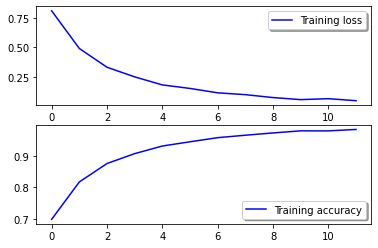

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
# ax[0].plot(history.history['validation_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

**Confusion matrix**

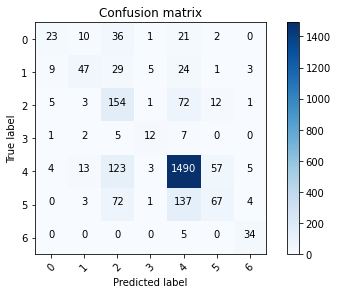

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 